<a href="https://colab.research.google.com/github/saquibali7/GANs/blob/main/task01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import load
from numpy.random import randint
from PIL import Image
import cv2

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.utils import save_image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Morula/'
file = os.listdir(path)
print(len(file))

1478


(500, 500, 3)


(-0.5, 499.5, 499.5, -0.5)

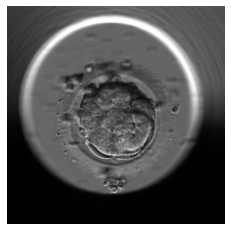

In [ ]:
ix = randint(0, len(file))
rand_img = Image.open(os.path.join(path,file[ix]))
rand_img = np.array(rand_img)
print(rand_img.shape)
plt.imshow(rand_img)
plt.axis("off")

### Discriminator Model

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_channels, features):
    super(Discriminator, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, features, 4, 2, 1),
        nn.LeakyReLU(0.2),
        self.CNNBlocks(features, features*2, 4, 2, 1),
        self.CNNBlocks(features*2, features*4, 4, 2, 1),
        self.CNNBlocks(features*4, features*8, 4, 2, 1),
        nn.Conv2d(features*8, 1, 4, 2, 0),
        nn.Sigmoid(),
    )

  def CNNBlocks(self, in_channels, out_channels, kernel_size, stride, padding):
      self.block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels,
                    kernel_size = kernel_size,
                    stride = stride,
                    padding = padding, bias=False),
      )
      return self.block

  def forward(self, x):
    return self.conv(x)    


In [ ]:
def test_disc():
  x = torch.rand((1, 3, 64, 64))
  disc = Discriminator(in_channels = 3, features = 64)
  out = disc(x).reshape(-1)
  print(out.shape)

In [ ]:
test_disc()

torch.Size([1])


## Generator Model

In [ ]:
class Generator(nn.Module):
  def __init__(self, noise_channels, img_channels, features):
    super().__init__()
    self.conv = nn.Sequential(
        self.CNNBlocks(noise_channels, features*16, 4, 2, 0),
        self.CNNBlocks(features*16, features*8, 4, 2, 1),
        self.CNNBlocks(features*8, features*4, 4, 2, 1),
        self.CNNBlocks(features*4, features*2, 4, 2, 1),
        nn.ConvTranspose2d(features*2, img_channels, 4, 2 , 1),
        nn.Tanh(),
    )

  def CNNBlocks(self, in_channels, out_channels, kernel_size, stride, padding):
    self.block= nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels,
                           kernel_size=kernel_size,
                           stride = stride,
                           padding = padding,
                           bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )  
    return self.block

  def forward(self, x):
    return self.conv(x)  

In [ ]:
def test_gen():
  x = torch.randn((1, 100, 1 , 1))
  gen = Generator(100, 3, 8)
  out = gen(x)
  print(out.shape)

In [ ]:
test_gen()

torch.Size([1, 3, 64, 64])


In [ ]:
def initialise_weight(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)


## Data Preprocessing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
IMAGE_SIZE = 64
IMG_CHANNELS = 3
NOISE_DIM = 100
LEARNING_RATE = 2e-4
EPOCHS = 250
DISC_FEATURES = 64
GEN_FEATURES = 64

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
train_transforms = A.Compose(
    [   
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(
         [0.5 for _ in range(IMG_CHANNELS)], [0.5 for _ in range(IMG_CHANNELS)]
        ),
        ToTensorV2(),
    ]
)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.files = os.listdir(root_dir)
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    img_file = self.files[idx]
    img_path = os.path.join(self.root_dir, img_file)
    img = np.array(Image.open(img_path))
    if self.transform:
      img = self.transform(image=img)['image']
    return img



In [ ]:
dataset = ImageDataset(root_dir=path, transform=train_transforms)
loader = DataLoader(dataset, batch_size = BATCH_SIZE)

torch.Size([3, 64, 64])
tensor(1.)


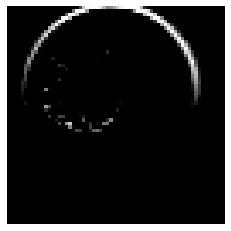

In [ ]:
for batch , image in enumerate(loader):
  print(image[3].shape)
  print( torch.max(image[0]))
  plt.imshow(image[0].permute(1, 2, 0))
  plt.axis("off")
  break

In [ ]:
disc = Discriminator(IMG_CHANNELS, DISC_FEATURES).to(device)
gen = Generator(NOISE_DIM, IMG_CHANNELS, GEN_FEATURES).to(device)

In [ ]:
initialise_weight(disc)
initialise_weight(gen)

opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE,betas=(0.5, 0.999))
opt_gen = optim.Adam(disc.parameters(), lr=LEARNING_RATE,betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [ ]:
from torch.utils.tensorboard import SummaryWriter
fixed_noise = torch.randn(32, NOISE_DIM, 1,1).to(device)
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")

In [ ]:
step=0
disc.train()
gen.train()

Generator(
  (block): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTr

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 25.2 MB/s 
     |████████████████████████████████| 157 kB 39.6 MB/s 
     |████████████████████████████████| 181 kB 67.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 157 kB 70.9 MB/s 
     |████████████████████████████████| 156 kB 75.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=626856b5df3ccc13c730b2c9f7f8988fc81e63c50f8f6d360bbda399cc0f4052
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import wandb
from torchvision.utils import make_grid

In [ ]:

wandb.init("task-01")

for epoch in range(EPOCHS):
  for idx, real in enumerate(loader):
    real = real.to(device)
    noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
    fake = gen(noise)

    ## train discriminator
    disc_real = disc(real).reshape(-1)
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(fake.detach()).reshape(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    loss_disc = (loss_disc_real + loss_disc_fake)/2

    disc.zero_grad()
    loss_disc.backward()
    opt_disc.step()

    ## train generator
    out = disc(fake).reshape(-1)
    loss_gen = criterion(out, torch.ones_like(out))
    
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

  wandb.log({"Generartor  Loss": loss_gen, 'epoch':epoch })
  wandb.log({"Discriminator Loss": loss_disc, 'epoch':epoch })

  with torch.inference_mode():
   for batch_idx, real_img in enumerate(loader):
     noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
     fake_img = gen(noise)
     grid1 = make_grid(real_img)
     grid2 = make_grid(fake_img)
     grid1 = wandb.Image(grid1, caption="Low Resolution Image")
     grid2 = wandb.Image(grid2, caption="High Resolution Image")
     wandb.log({"Original Image ": grid1})
     wandb.log({"Fake Image": grid2})